In [3]:
%pip install glom transformers datasets bitsandbytes accelerate peft hf_transfer matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 111.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 31.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 59.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━

In [4]:
%pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.9 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=188930485 sha256=f242b686e89e4bd88474ac4ceb7a5b19d738b4e63e2132f50edd7b6f397f8654
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash-attn

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

os.environ['HF_HOME'] = '/workspace/.hf'
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer

class MergedModulesMixin:
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._merged_modules = []

    def register_merged_module(self, module):
        self._merged_modules.append(module)

    def merged_modules(self):
        return self._merged_modules

    def set_forward_type(self, forward_type):
        for module in self._merged_modules:
            module.set_forward_type(forward_type)


class MergedModel(MergedModulesMixin, AutoModelForCausalLM):
    pass

In [2]:
MODEL_ID = "mistralai/Mistral-7B-v0.1"
MODEL_ID_A = "augmxnt/shisa-gamma-7b-v1"
MODEL_ID_B = "WizardLM/WizardMath-7B-V1.1"
MODEL_ID_C = "GAIR/Abel-7B-002"

base_model = MergedModel.from_pretrained(MODEL_ID, torch_dtype=torch.bfloat16, device_map="auto")
model_A = AutoModelForCausalLM.from_pretrained(MODEL_ID_A, torch_dtype=torch.bfloat16, device_map="auto")
model_B = AutoModelForCausalLM.from_pretrained(MODEL_ID_B, torch_dtype=torch.bfloat16, device_map="auto")
model_C = AutoModelForCausalLM.from_pretrained(MODEL_ID_C, torch_dtype=torch.bfloat16, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
import os
import torch
import torch
import bitsandbytes as bnb
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
from peft.tuners.lora import QuantLinear

def find_embedding(model):
    cls = (torch.nn.Embedding)

    names = []
    for name, module in model.named_modules():
        if (
            isinstance(module, cls)
        ):
            names.append(name)


    return names

def find_all_linear_names(model):
    cls = (bnb.nn.Linear4bit, bnb.nn.Linear8bitLt, torch.nn.Linear, QuantLinear)

    names = []
    for name, module in model.named_modules():
        if (
            isinstance(module, cls)
            or "Linear" in module.__class__.__name__
            and module.__class__.__name__ not in ("LlamaLinearScalingRotaryEmbedding",)
        ):
            names.append(name)


    return names

In [4]:
modules = find_all_linear_names(base_model) + find_embedding(base_model)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ZipLoRATripleBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.forward_type = "merge"

    def set_forward_type(self, type: str = "merge"):
        assert type in ["merge", "weight_1", "weight_2", "weight_3"]
        self.forward_type = type

    def compute_mergers_similarity(self):
        sim_12 = F.cosine_similarity(self.merger_1, self.merger_2, dim=0)
        sim_13 = F.cosine_similarity(self.merger_1, self.merger_3, dim=0)
        sim_23 = F.cosine_similarity(self.merger_2, self.merger_3, dim=0)
    
        return (sim_12 + sim_13 + sim_23) / 3

    def unfreeze(self):
        self.merger_1.requires_grad = True
        self.merger_2.requires_grad = True
        self.merger_3.requires_grad = True

    def get_ziplora_weight(self):
        raise NotImplementedError

    def forward(self, *args, **kwargs):
        raise NotImplementedError


In [5]:
class ZipLoRATripleEmbedding(ZipLoRATripleBase):
    def __init__(self, embedding_a, embedding_b, embedding_c, init_merger_value=0.33, init_merger_value_2=0.33, init_merger_value_3=0.33, device=None, dtype=None):
        super().__init__()
        
        assert (embedding_a.num_embeddings == embedding_b.num_embeddings == embedding_c.num_embeddings), "Number of embeddings must match"
        assert (embedding_a.embedding_dim == embedding_b.embedding_dim == embedding_c.embedding_dim), "Embedding dimensions must match"

        self.num_embeddings = embedding_a.num_embeddings
        self.embedding_dim = embedding_a.embedding_dim
        self.padding_idx = embedding_a.padding_idx
        self.max_norm = embedding_a.max_norm
        self.norm_type = embedding_a.norm_type
        self.scale_grad_by_freq = embedding_a.scale_grad_by_freq
        self.sparse = embedding_a.sparse

        self.register_buffer('weight_1', embedding_a.weight.data)
        self.register_buffer('weight_2', embedding_b.weight.data)
        self.register_buffer('weight_3', embedding_c.weight.data)

        self.merger_1 = Parameter(
            torch.ones((self.num_embeddings,), device=embedding_a.weight.data.device, dtype=dtype) * init_merger_value
        )
        self.merger_2 = Parameter(
            torch.ones((self.num_embeddings,), device=embedding_b.weight.data.device, dtype=dtype) * init_merger_value_2
        )
        self.merger_3 = Parameter(
            torch.ones((self.num_embeddings,), device=embedding_c.weight.data.device, dtype=dtype) * init_merger_value_3
        )
        
        self.forward_type = "merge"
        
    def get_ziplora_weight(self):
        return self.merger_1.unsqueeze(1) * self.weight_1 + self.merger_2.unsqueeze(1) * self.weight_2 + self.merger_3.unsqueeze(1) * self.weight_3

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        if self.forward_type == "merge":
            weight = self.get_ziplora_weight()
        elif self.forward_type == "weight_1":
            weight = self.weight_1
        elif self.forward_type == "weight_2":
            weight = self.weight_2
        elif self.forward_type == "weight_3":
            weight = self.weight_3
        else:
            raise ValueError(self.forward_type)
            
        return F.embedding(
            input,
            weight,
            self.padding_idx,
            self.max_norm,
            self.norm_type,
            self.scale_grad_by_freq,
            self.sparse
        )


In [6]:
class ZipLoRATripleLinearLayer(ZipLoRATripleBase):
    def __init__(self, linear_a, linear_b, linear_c, init_merger_value=0.33, init_merger_value_2=0.33, init_merger_value_3=0.33, device=None, dtype=None):
        super().__init__()
        
        assert linear_a.in_features == linear_b.in_features == linear_c.in_features, "Input features must match"
        assert linear_a.out_features == linear_b.out_features == linear_c.out_features, "Output features must match"

        self.in_features = linear_a.in_features
        self.out_features = linear_a.out_features

        self.register_buffer('weight_1', linear_a.weight.data.clone())
        self.register_buffer('weight_2', linear_b.weight.data.clone())
        self.register_buffer('weight_3', linear_c.weight.data.clone())

        if linear_a.bias is not None and linear_b.bias is not None and linear_c.bias is not None:
            self.register_buffer('bias1', linear_a.bias.data.clone())
            self.register_buffer('bias2', linear_b.bias.data.clone())
            self.register_buffer('bias3', linear_c.bias.data.clone())
            self.bias_merger1 = nn.Parameter(torch.ones(1, device=linear_a.bias.data.device, dtype=dtype) * init_merger_value)
            self.bias_merger2 = nn.Parameter(torch.ones(1, device=linear_b.bias.data.device, dtype=dtype) * init_merger_value_2)
            self.bias_merger3 = nn.Parameter(torch.ones(1, device=linear_c.bias.data.device, dtype=dtype) * init_merger_value_3)
        else:
            self.register_buffer('bias1', None)
            self.register_buffer('bias2', None)
            self.register_buffer('bias3', None)
            self.register_parameter('bias_merger1', None)
            self.register_parameter('bias_merger2', None)
            self.register_parameter('bias_merger3', None)

        # Merger parameters
        self.merger_1 = nn.Parameter(
            torch.ones((self.in_features,), device=linear_a.weight.data.device, dtype=dtype) * init_merger_value
        )
        self.merger_2 = nn.Parameter(
            torch.ones((self.in_features,), device=linear_b.weight.data.device, dtype=dtype) * init_merger_value_2
        )
        self.merger_3 = nn.Parameter(
            torch.ones((self.in_features,), device=linear_c.weight.data.device, dtype=dtype) * init_merger_value_3
        )
        
        self.forward_type = "merge"
        
    def get_ziplora_weight(self):
        return self.merger_1 * self.weight_1 + self.merger_2 * self.weight_2 + self.merger_3 * self.weight_3
    
    def get_ziplora_bias(self):
        if self.bias1 is not None:
            return self.bias_merger1 * self.bias1 + self.bias_merger2 * self.bias2 + self.bias_merger3 * self.bias3
        return None

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        orig_dtype = hidden_states.dtype
        dtype = self.weight_1.dtype
        if self.forward_type == "merge":
            weight = self.get_ziplora_weight()
            bias = self.get_ziplora_bias()
        elif self.forward_type == "weight_1":
            weight = self.weight_1
            bias = self.bias1
        elif self.forward_type == "weight_2":
            weight = self.weight_2
            bias = self.bias2
        elif self.forward_type == "weight_3":
            weight = self.weight_3
            bias = self.bias3
        else:
            raise ValueError(self.forward_type)
        
        hidden_states = F.linear(hidden_states.to(dtype), weight=weight, bias=bias)
        return hidden_states.to(orig_dtype)


In [ ]:
import torch
import torch.nn as nn


# model_C (GAIR/Abel-7B-002) has a bigger vocab, we truncate the embedding layers

truncated_lm_head = nn.Linear(in_features=4096, out_features=32000, bias=False)
truncated_embed = nn.Embedding(num_embeddings=32000, embedding_dim=4096)

with torch.no_grad():
    truncated_lm_head.weight.data = model_C.lm_head.weight.data[:32000, :]
    truncated_embed.weight.data = model_C.model.embed_tokens.weight.data[:32000, :]

assign_embed = Assign('model.embed_tokens', truncated_embed)
assign_lm_head = Assign('lm_head', truncated_lm_head)
glom(model_C, assign_embed)
glom(model_C, assign_lm_head)

In [10]:
from tqdm import tqdm
from glom import glom, Assign

for m in tqdm(modules):
    module_a = glom(model_A, m)
    module_b = glom(model_B, m)
    module_c = glom(model_C, m)

    zipped = None

    if isinstance(module_a, torch.nn.Embedding):    
        zipped = ZipLoRATripleEmbedding(
            embedding_a=module_a,
            embedding_b=module_b,
            embedding_c=module_c,
            device=base_model.device,
            dtype=module_a.weight.dtype
        )
    else:
        zipped = ZipLoRATripleLinearLayer(
            linear_a=module_a,
            linear_b=module_b,
            linear_c=module_c,
            device=base_model.device,
            dtype=module_a.weight.dtype
        )

    assign = Assign(m, zipped)
    glom(base_model, assign)
    base_model.register_merged_module(zipped)

100%|██████████| 226/226 [00:00<00:00, 641.32it/s]


In [13]:
from transformers import pipeline

generator = pipeline(model=base_model, task='text-generation', tokenizer=tokenizer)

prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Who is the most famous president?

### Response:
"""

print(generator(prompt, do_sample=True, max_new_tokens=64)[0]['generated_text'][len(prompt):])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1. Abraham Lincoln is considered by many to be the most famous president in U.S. history. He led the country through the Civil War and issued the Emancipation Proclamation, which ended slavery in the Confederate states. Lincoln is also known for delivering the Gettysburg Address, one of


In [11]:
import gc
model_A.cpu()
model_B.cpu()
model_C.cpu()

del model_A, model_B, model_C
gc.collect()
torch.cuda.empty_cache()

In [12]:
tokenizer.chat_template = "{%- set ns = namespace(found=false) -%}\n{%- for message in messages -%}\n    {%- if message['role'] == 'system' -%}\n        {%- set ns.found = true -%}\n    {%- endif -%}\n{%- endfor -%}\n{%- if not ns.found -%}\n    {{- '' + 'Below is an instruction that describes a task. Write a response that appropriately completes the request.' + '\\n\\n' -}}\n{%- endif %}\n{%- for message in messages %}\n    {%- if message['role'] == 'system' -%}\n        {{- '' + message['content'] + '\\n\\n' -}}\n    {%- else -%}\n        {%- if message['role'] == 'user' -%}\n            {{-'### Instruction:\\n' + message['content'] + '\\n\\n'-}}\n        {%- else -%}\n            {{-'### Response:\\n' + message['content'] + '\\n\\n' -}}\n        {%- endif -%}\n    {%- endif -%}\n{%- endfor -%}\n{%- if add_generation_prompt -%}\n    {{-'### Response:\\n'-}}\n{%- endif -%}"

In [13]:
from datasets import load_dataset

dataset_A = load_dataset("p1atdev/ichikara-instruction", '20231115-1').rename_column("text", "instruction")

Generating train split:   0%|          | 0/1729 [00:00<?, ? examples/s]

In [14]:
templated_dataset_A = dataset_A.map(lambda row: {'text' : tokenizer.apply_chat_template([{'role': 'user', 'content': row['instruction']}, {'role': 'assistant', 'content': row['output'] }], tokenize=False).strip()})

Map:   0%|          | 0/1729 [00:00<?, ? examples/s]

In [15]:
from datasets import load_dataset

dataset_B = load_dataset("microsoft/orca-math-word-problems-200k")

Generating train split:   0%|          | 0/200035 [00:00<?, ? examples/s]

In [16]:
templated_dataset_B = dataset_B.map(lambda row: {'text' : tokenizer.apply_chat_template([{'role': 'user', 'content': row['question']}, {'role': 'assistant', 'content': row['answer'] }], tokenize=False).strip()})

Map:   0%|          | 0/200035 [00:00<?, ? examples/s]

In [17]:
from datasets import load_dataset

dataset_C = load_dataset("meta-math/MetaMathQA")

Generating train split:   0%|          | 0/395000 [00:00<?, ? examples/s]

In [18]:
templated_dataset_C = dataset_C.map(lambda row: {'text' : tokenizer.apply_chat_template([{'role': 'user', 'content': row['query']}, {'role': 'assistant', 'content': row['response'] }], tokenize=False).strip()})

Map:   0%|          | 0/395000 [00:00<?, ? examples/s]

In [23]:
for module in base_model.modules():
    if isinstance(module, ZipLoRATripleLinearLayer) or isinstance(module, ZipLoRATripleEmbedding):
        for param in module.parameters():
            param.requires_grad = True
    else:
        for param in module.parameters():
            param.requires_grad = False

In [20]:
def compute_ziplora_loss_for_lm(model, prompt_a, prompt_b, prompt_c, lambda_coef=0.01, temperature=2.0):
    # Tokenize inputs
    batch = tokenizer([prompt_a, prompt_b, prompt_c], padding="max_length", truncation=True, max_length=4096, return_tensors='pt')

    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)

    # Split inputs for a, b, and c
    input_a = input_ids[0].to(model.device)
    input_b = input_ids[1].to(model.device)
    input_c = input_ids[2].to(model.device)

    # Prepare labels (shifted input_ids)
    labels = batch["input_ids"].clone()
    labels[attention_mask == 0] = -100  # Set padding token positions to -100

    labels_a = labels[0].to(model.device)
    labels_b = labels[1].to(model.device)
    labels_c = labels[2].to(model.device)

    with torch.no_grad():
        # Get logits from model_A
        model.set_forward_type('weight_1')
        original_logits_a = model(input_ids=input_a.unsqueeze(0), labels=labels_a.unsqueeze(0)).logits

        # Get logits from model_B
        model.set_forward_type('weight_2')
        original_logits_b = model(input_ids=input_b.unsqueeze(0), labels=labels_b.unsqueeze(0)).logits

        # Get logits from model_C
        model.set_forward_type('weight_3')
        original_logits_c = model(input_ids=input_c.unsqueeze(0), labels=labels_c.unsqueeze(0)).logits

    model.set_forward_type('merge')

    # Get logits from merged model for all inputs
    merged_logits_a = model(input_ids=input_a.unsqueeze(0), labels=labels_a.unsqueeze(0)).logits
    merged_logits_b = model(input_ids=input_b.unsqueeze(0), labels=labels_b.unsqueeze(0)).logits
    merged_logits_c = model(input_ids=input_c.unsqueeze(0), labels=labels_c.unsqueeze(0)).logits

    # Calculate losses (KL divergence between merged and original logits)
    loss_a = F.kl_div(
        F.log_softmax(merged_logits_a / temperature, dim=-1),
        F.softmax(original_logits_a / temperature, dim=-1),
        reduction='batchmean'
    ) * (temperature ** 2) / len(input_a)
    
    loss_b = F.kl_div(
        F.log_softmax(merged_logits_b / temperature, dim=-1),
        F.softmax(original_logits_b / temperature, dim=-1),
        reduction='batchmean'
    ) * (temperature ** 2) / len(input_b)
    
    loss_c = F.kl_div(
        F.log_softmax(merged_logits_c / temperature, dim=-1),
        F.softmax(original_logits_c / temperature, dim=-1),
        reduction='batchmean'
    ) * (temperature ** 2) / len(input_c)
    
    # Calculate similarity loss to encourage diversity between mergers
    similarity_loss = torch.tensor(0.0)
    for module in base_model.modules():
        if isinstance(module, ZipLoRATripleLinearLayer) or isinstance(module, ZipLoRATripleEmbedding):
            similarity_loss += module.compute_mergers_similarity().to(similarity_loss.device)
    
    # Combine losses
    total_loss = loss_a + loss_b + loss_c + lambda_coef * similarity_loss

    return total_loss

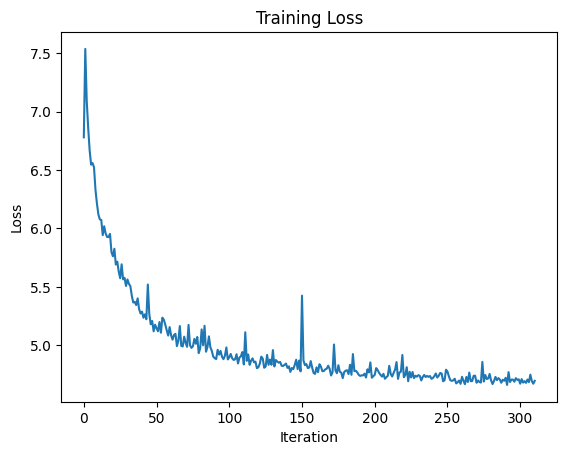

Epoch 1/1:  18%|█▊        | 313/1729 [43:44<3:18:03,  8.39s/it, loss=4.6893]

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

tokenizer.pad_token = tokenizer.eos_token
optimizer = torch.optim.AdamW([p for p in base_model.parameters() if p.requires_grad], lr=1e-3)

num_epochs = 1

plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
losses = []

for epoch in range(num_epochs):
    base_model.train()
    total_loss = 0
    
    progress_bar = tqdm(zip(
        random.sample(templated_dataset_A['train']['text'], len(templated_dataset_A['train']['text'])),
        random.sample(templated_dataset_B['train']['text'], len(templated_dataset_B['train']['text'])),
        random.sample(templated_dataset_C['train']['text'], len(templated_dataset_C['train']['text']))
    ), 
    total=min([len(templated_dataset_A['train']['text']), len(templated_dataset_B['train']['text']), len(templated_dataset_C['train']['text'])]),
    desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (prompt_a, prompt_b, prompt_c) in enumerate(progress_bar):
        loss = compute_ziplora_loss_for_lm(base_model, prompt_a, prompt_b, prompt_c)

        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        current_loss = loss.item()
        total_loss += current_loss
        losses.append(current_loss)

        progress_bar.set_postfix({'loss': f'{current_loss:.4f}'})

        if i % 10 == 0:
            clear_output(wait=True)
            plt.clf()
            plt.plot(losses)
            plt.title("Training Loss")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()

        if i > 550:
            break
    
    avg_loss = total_loss / len(progress_bar)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

plt.figure(figsize=(10,5))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
import torch
from transformers import AutoModelForCausalLM
from tqdm import tqdm

# Create a new model instance with the same architecture as the base model
new_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.bfloat16)

# Iterate through all modules and update weights for ZipLoRALinearLayers
for (name, module), (_, new_module) in tqdm(zip(base_model.named_modules(), new_model.named_modules()), 
                                            desc="Merging layers"):
    if isinstance(module, ZipLoRATripleLinearLayer):
        # Get the merged weight and bias
        merged_weight = module.get_ziplora_weight()
        merged_bias = module.get_ziplora_bias()
        
        # Update the weights and bias of the corresponding layer in the new model
        new_module.weight.data = merged_weight
        if merged_bias is not None:
            new_module.bias.data = merged_bias
            
    if isinstance(module, ZipLoRATripleEmbedding):
        merged_weight = module.get_ziplora_weight()
        new_module.weight.data = merged_weight

# Save the new model
new_model.save_pretrained("/workspace/zip_merged-again")
tokenizer.save_pretrained("/workspace/zip_merged-again")

print("Merged model saved successfully!")